In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import TfidfModel
from gensim.corpora import Dictionary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split

# Loading Data

In [2]:
df = pd.read_csv('../data/interim/preproc.csv', index_col=0)
df.head()

,key,project_id,creation_date,resolution_date,type,lines_added,lines_removed,files_changed,duration,text,inter_text
0,EXEC-108,commons-exec,2018-09-18T11:15:58.000+0000,NaN,Bug,0,0,0,NaN,compatibility problem android adb using apache...,compatibility problem with android adb when us...
1,EXEC-107,commons-exec,2018-07-04T12:09:47.000+0000,NaN,New Feature,0,0,0,NaN,start independent process hi would like start ...,start independent process hi i would like to s...
2,EXEC-106,commons-exec,2018-03-06T11:32:51.000+0000,NaN,Improvement,0,0,0,NaN,watchdog class could use volatile instead sync...,watchdog class could use volatile instead of s...
3,EXEC-105,commons-exec,2018-02-16T13:47:10.000+0000,NaN,Wish,0,0,0,NaN,small mistake documentation apache common exec...,small mistakes in the documentation for apache...
4,EXEC-104,commons-exec,2017-08-04T11:57:39.000+0000,NaN,Bug,0,0,0,NaN,test failure watchdog killed process URL watch...,test failure 88 watchdog should have killed th...


# Tf-Idf model

In [3]:
'''txts = [line.split(" ") for line in df['text']]
dct = Dictionary(txts)  # fit dictionary
corpus = [dct.doc2bow(txt) for txt in txts]  # convert corpus to BoW format

model = TfidfModel(corpus)  # fit model
vector = model[corpus[0]]  # apply model to the first corpus document'''

'txts = [line.split(" ") for line in df[\'text\']]\ndct = Dictionary(txts)  # fit dictionary\ncorpus = [dct.doc2bow(txt) for txt in txts]  # convert corpus to BoW format\n\nmodel = TfidfModel(corpus)  # fit model\nvector = model[corpus[0]]  # apply model to the first corpus document'

In [44]:
varname = 'duration'
df = df.dropna()
df[f'median_{varname}'] = df[varname].groupby(df['project_id']).transform('median')
df['class'] = [1 if x else 0 for x in (df[varname] > df[f'median_{varname}'])]
df = df.drop(columns=[f'median_{varname}'])

In [45]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['text'])
svd = TruncatedSVD(n_components=100, random_state=123)
X_svd = svd.fit_transform(X_tfidf)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_svd, df['class'], test_size=0.30, random_state=123)

In [47]:
clf = LogisticRegression().fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.5679175299071042, 0.5599391836575572)

In [7]:
#clf = SVC(gamma='auto').fit(X_svd, df['class'])
#clf.score(X_svd, df['class'])

In [48]:
gnb = GaussianNB().fit(X_train, y_train)
gnb.score(X_train, y_train), gnb.score(X_test, y_test)

(0.530826037559313, 0.5311293906670306)

In [49]:
rfc = RandomForestClassifier(max_depth=5,n_estimators=500).fit(X_train, y_train)

In [50]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.5879836931096705, 0.5538575494132782)

## USing Chi-2

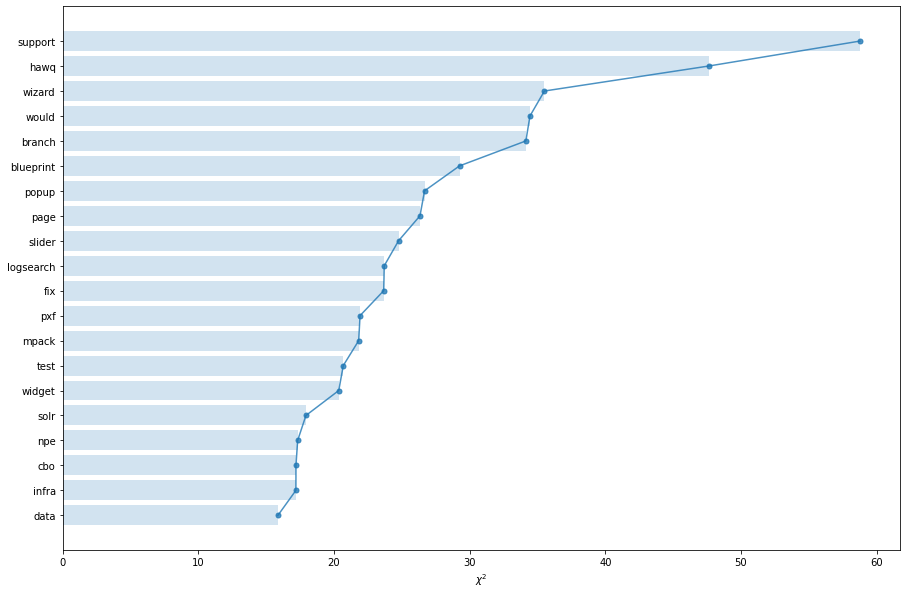

In [65]:
from sklearn.feature_selection import SelectKBest, chi2

Xtfidf_train, Xtfidf_test, y_train, y_test = train_test_split(X_tfidf, df['class'], test_size=0.30, random_state=123)

chi2score = chi2(X_tfidf, df['class'])[0]

plt.figure(figsize=(15,10))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$');

In [66]:
ch2_result = []
for n in np.arange(10000,100000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(Xtfidf_train, y_train)
    x_validation_chi2_selected = ch2.transform(Xtfidf_test)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_test)
    ch2_result.append(score)
    print(f"chi2 feature selection evaluation calculated for {n} features")

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 10000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 20000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 30000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 40000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 50000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 60000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 70000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


chi2 feature selection evaluation calculated for 80000 features
chi2 feature selection evaluation calculated for 90000 features


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
ch2_result

[0.5923355814588125,
 0.5923745662937118,
 0.5925694904682078,
 0.5929983236520994,
 0.5931542629916963,
 0.5937000506802854,
 0.5929593388172001,
 0.5922965966239133,
 0.5915948695957273]